In [1]:
!pip install timm
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

#positional embeddings
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None]

In [3]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [4]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        length = x.shape[2]
        x = rearrange(x, 'b c l -> b l c')
        x = self.proj1(x)
        x = rearrange(x, 'b l (C H K) -> K b H l C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H l C -> b l (C H)')
        x = self.proj2(x)
        return rearrange(x, 'b l C -> b C l')

In [5]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            last_layer: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale and not last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1)
        elif last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        else:
            self.conv = nn.Conv1d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [6]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            last_layers: List = [False, False, False, False, False, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv1d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv1d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv1d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                last_layer=last_layers[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [7]:
model = UNET()

# Generate a random 1D input tensor of shape (batch_size, input_channels, length)
batch_size = 1  # You can change this to whatever batch size you need
input_length = 34  # As specified
input_tensor = torch.randn(batch_size, 1, input_length)  # Shape: (1, 1, 34)

# Generate a random time step tensor
time_steps = torch.randint(0, 1000, (batch_size,))  # Randomly generating time steps

# Pass the input tensor through the model
output = model(input_tensor, time_steps)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 34])


In [8]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [9]:
#optional set seed
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [11]:
data = np.load('/kaggle/input/1millionpixelspectra/1mil_pixel_data.npy')
#reshape it to (size, channels, length)
data = data.reshape((-1, 1, 34))
data.shape

(1000000, 1, 34)

In [12]:
class SpectralDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [13]:
import os
def train(batch_size: int=250,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = SpectralDataset(data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_dataloader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (1000000/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, '/kaggle/working/ddpm_checkpoint.pth')

In [16]:
train(checkpoint_path='/kaggle/working/ddpm_checkpoint.pth', lr=2e-5, num_epochs=100)

/tmp/ipykernel_30/1004385560.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/100: 100%|██████████| 4000/4000 [05:09<00:

Epoch 1 | Loss 0.01789


Epoch 2/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 2 | Loss 0.01497


Epoch 3/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 3 | Loss 0.01358


Epoch 4/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 4 | Loss 0.01278


Epoch 5/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 5 | Loss 0.01215


Epoch 6/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 6 | Loss 0.01172


Epoch 7/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 7 | Loss 0.01138


Epoch 8/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 8 | Loss 0.01109


Epoch 9/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 9 | Loss 0.01082


Epoch 10/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 10 | Loss 0.01069


Epoch 11/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 11 | Loss 0.01057


Epoch 12/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 12 | Loss 0.01040


Epoch 13/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 13 | Loss 0.01031


Epoch 14/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 14 | Loss 0.01011


Epoch 15/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 15 | Loss 0.01011


Epoch 16/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 16 | Loss 0.00998


Epoch 17/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 17 | Loss 0.00980


Epoch 18/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 18 | Loss 0.00985


Epoch 19/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 19 | Loss 0.00977


Epoch 20/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 20 | Loss 0.00966


Epoch 21/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 21 | Loss 0.00964


Epoch 22/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 22 | Loss 0.00961


Epoch 23/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 23 | Loss 0.00954


Epoch 24/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 24 | Loss 0.00942


Epoch 25/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 25 | Loss 0.00946


Epoch 26/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 26 | Loss 0.00947


Epoch 27/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 27 | Loss 0.00941


Epoch 28/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.91it/s]


Epoch 28 | Loss 0.00937


Epoch 29/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 29 | Loss 0.00929


Epoch 30/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 30 | Loss 0.00926


Epoch 31/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 31 | Loss 0.00925


Epoch 32/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 32 | Loss 0.00921


Epoch 33/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 33 | Loss 0.00918


Epoch 34/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 34 | Loss 0.00921


Epoch 35/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 35 | Loss 0.00913


Epoch 36/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 36 | Loss 0.00922


Epoch 37/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 37 | Loss 0.00911


Epoch 38/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 38 | Loss 0.00911


Epoch 39/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 39 | Loss 0.00912


Epoch 40/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.92it/s]


Epoch 40 | Loss 0.00905


Epoch 41/100: 100%|██████████| 4000/4000 [05:11<00:00, 12.86it/s]


Epoch 41 | Loss 0.00907


Epoch 42/100: 100%|██████████| 4000/4000 [05:10<00:00, 12.86it/s]


Epoch 42 | Loss 0.00905


Epoch 43/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.94it/s]


Epoch 43 | Loss 0.00897


Epoch 44/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 44 | Loss 0.00901


Epoch 45/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 45 | Loss 0.00899


Epoch 46/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 46 | Loss 0.00902


Epoch 47/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 47 | Loss 0.00900


Epoch 48/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 48 | Loss 0.00890


Epoch 49/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 49 | Loss 0.00897


Epoch 50/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 50 | Loss 0.00896


Epoch 51/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 51 | Loss 0.00888


Epoch 52/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 52 | Loss 0.00888


Epoch 53/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 53 | Loss 0.00889


Epoch 54/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 54 | Loss 0.00890


Epoch 55/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 55 | Loss 0.00887


Epoch 56/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 56 | Loss 0.00887


Epoch 57/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 57 | Loss 0.00886


Epoch 58/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.93it/s]


Epoch 58 | Loss 0.00882


Epoch 59/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 59 | Loss 0.00882


Epoch 60/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 60 | Loss 0.00887


Epoch 61/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 61 | Loss 0.00883


Epoch 62/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 62 | Loss 0.00879


Epoch 63/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 63 | Loss 0.00884


Epoch 64/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 64 | Loss 0.00881


Epoch 65/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.90it/s]


Epoch 65 | Loss 0.00881


Epoch 66/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 66 | Loss 0.00878


Epoch 67/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 67 | Loss 0.00876


Epoch 68/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 68 | Loss 0.00879


Epoch 69/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 69 | Loss 0.00876


Epoch 70/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 70 | Loss 0.00878


Epoch 71/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 71 | Loss 0.00871


Epoch 72/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.91it/s]


Epoch 72 | Loss 0.00871


Epoch 73/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 73 | Loss 0.00873


Epoch 74/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 74 | Loss 0.00874


Epoch 75/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 75 | Loss 0.00872


Epoch 76/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 76 | Loss 0.00873


Epoch 77/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 77 | Loss 0.00869


Epoch 78/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.94it/s]


Epoch 78 | Loss 0.00870


Epoch 79/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 79 | Loss 0.00873


Epoch 80/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 80 | Loss 0.00865


Epoch 81/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 81 | Loss 0.00873


Epoch 82/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 82 | Loss 0.00874


Epoch 83/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 83 | Loss 0.00875


Epoch 84/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 84 | Loss 0.00868


Epoch 85/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 85 | Loss 0.00870


Epoch 86/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 86 | Loss 0.00862


Epoch 87/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 87 | Loss 0.00867


Epoch 88/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 88 | Loss 0.00866


Epoch 89/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 89 | Loss 0.00864


Epoch 90/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 90 | Loss 0.00867


Epoch 91/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 91 | Loss 0.00863


Epoch 92/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 92 | Loss 0.00861


Epoch 93/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 93 | Loss 0.00866


Epoch 94/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.01it/s]


Epoch 94 | Loss 0.00865


Epoch 95/100: 100%|██████████| 4000/4000 [05:07<00:00, 13.00it/s]


Epoch 95 | Loss 0.00862


Epoch 96/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 96 | Loss 0.00859


Epoch 97/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.91it/s]


Epoch 97 | Loss 0.00862


Epoch 98/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 98 | Loss 0.00861


Epoch 99/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 99 | Loss 0.00856


Epoch 100/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 100 | Loss 0.00860


In [17]:
def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    spectra = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 34)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/((torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t]))))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                #if t[0] in times:
                    #spectra.append(z.clone())
                e = torch.randn(1, 1, 34)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/((torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            x = x.squeeze(0).detach().numpy()
            spectra.append(x)
    return spectra

In [18]:
spectra = inference('/kaggle/working/ddpm_checkpoint.pth')

/tmp/ipykernel_30/734865899.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [19]:
import numpy as np
data = np.load("/kaggle/input/1millionpixelspectra/1mil_pixel_data.npy")

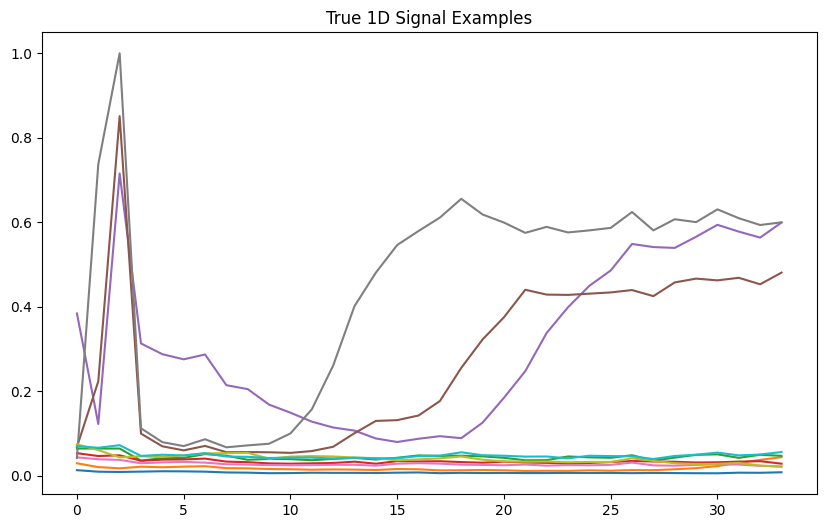

In [21]:
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(10):
  rand = random.randint(0,1000000)
  plt.plot(data[rand])
#plt.ylim(0.01,0.1)
plt.title("True 1D Signal Examples");

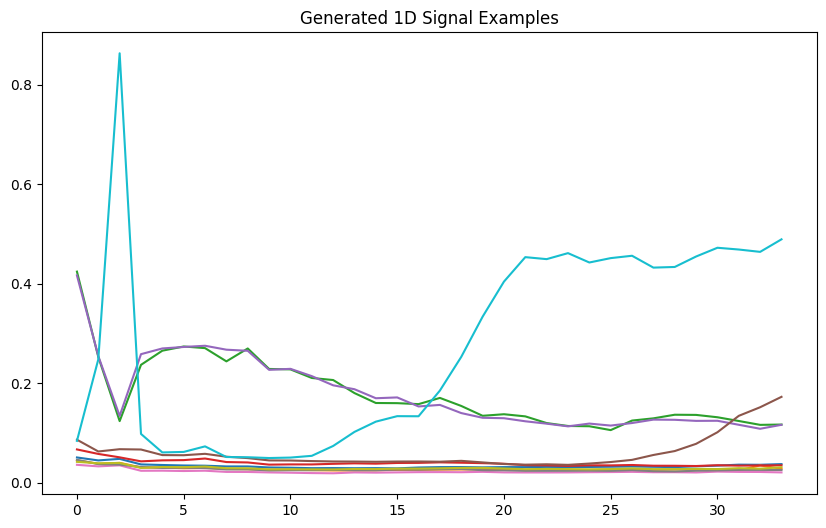

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i, spectrum in enumerate(spectra):
    # Squeeze the array to get rid of extra dimensions
    spectrum = spectrum.squeeze()
    plt.plot(range(34), spectrum)
    
plt.title('Generated 1D Signal Examples');